Proyecto Final de Machine Learning - Gonzalo Martín Lupi. Tema: Clasificación de Score de Crédito

In [66]:
# EDA
import matplotlib.pyplot as plt
import seaborn as sns 
import pandas as pd 
import numpy as np 
import plotly.express as px

# Data Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from datasist.structdata import detect_outliers
from sklearn.metrics import mean_squared_error
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
import category_encoders as ce
import re 

# Modelado
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import (
    BaggingClassifier,
    ExtraTreesClassifier,
    RandomForestClassifier,
    StackingClassifier,
    HistGradientBoostingClassifier
)
from xgboost import XGBClassifier
from sklearn.metrics import classification_report 
import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# Opciones extra
sns.set(rc={'figure.figsize': [14, 7]}, font_scale=1.2) # Standard figure size for all 
np.seterr(divide='ignore', invalid='ignore', over='ignore') ;

import warnings 
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore")

In [67]:
data = pd.read_csv('Credit_Score_Data/train.csv')
data.head()

ID  Customer_ID  Month           Name   Age          SSN Occupation  \
0  5634         3392      1  Aaron Maashoh  23.0  821000265.0  Scientist   
1  5635         3392      2  Aaron Maashoh  23.0  821000265.0  Scientist   
2  5636         3392      3  Aaron Maashoh  23.0  821000265.0  Scientist   
3  5637         3392      4  Aaron Maashoh  23.0  821000265.0  Scientist   
4  5638         3392      5  Aaron Maashoh  23.0  821000265.0  Scientist   

   Annual_Income  Monthly_Inhand_Salary  Num_Bank_Accounts  ...  Credit_Mix  \
0       19114.12            1824.843333                3.0  ...        Good   
1       19114.12            1824.843333                3.0  ...        Good   
2       19114.12            1824.843333                3.0  ...        Good   
3       19114.12            1824.843333                3.0  ...        Good   
4       19114.12            1824.843333                3.0  ...        Good   

   Outstanding_Debt  Credit_Utilization_Ratio Credit_History_Age  \
0            809.98                 26.822620              265.0   
1            809.98                 31.944960              266.0   
2            809.98                 28.609352              267.0   
3            809.98                 31.377862              268.0   
4            809.98                 24.797347              269.0   

   Payment_of_Min_Amount  Total_EMI_per_month  Amount_invested_monthly  \
0                     No            49.574949                 21.46538   
1                     No            49.574949                 21.46538   
2                     No            49.574949                 21.46538   
3                     No            49.574949                 21.46538   
4                     No            49.574949                 21.46538   

                  Payment_Behaviour Monthly_Balance  Credit_Score  
0   High_spent_Small_value_payments      312.494089          Good  
1    Low_spent_Large_value_payments      284.629162          Good  
2   Low_spent_Medium_value_payments      331.209863          Good  
3    Low_spent_Small_value_payments      223.451310          Good  
4  High_spent_Medium_value_payments      341.489231          Good  

[5 rows x 28 columns]

### EDA

In [68]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        100000 non-null  int64  
 1   Customer_ID               100000 non-null  int64  
 2   Month                     100000 non-null  int64  
 3   Name                      100000 non-null  object 
 4   Age                       100000 non-null  float64
 5   SSN                       100000 non-null  float64
 6   Occupation                100000 non-null  object 
 7   Annual_Income             100000 non-null  float64
 8   Monthly_Inhand_Salary     100000 non-null  float64
 9   Num_Bank_Accounts         100000 non-null  float64
 10  Num_Credit_Card           100000 non-null  float64
 11  Interest_Rate             100000 non-null  float64
 12  Num_of_Loan               100000 non-null  float64
 13  Type_of_Loan              100000 non-null  ob

In [69]:
data["Credit_Score"].value_counts(normalize = True)

Standard    0.53174
Poor        0.28998
Good        0.17828
Name: Credit_Score, dtype: float64

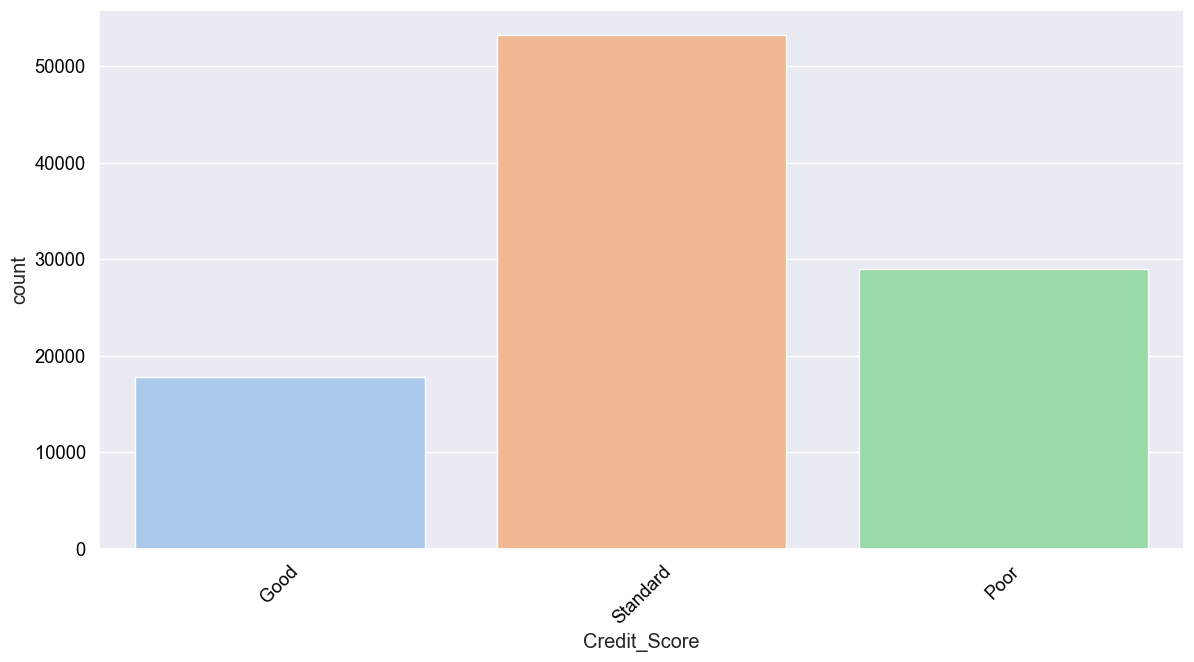

In [70]:
sns.countplot(data['Credit_Score'],palette="pastel")
plt.xticks(rotation=45, color = "black")
plt.tick_params(axis='y', colors='black')
#plt.ylabel('Count', color="white")
#plt.xlabel('Credit Score', color="white")
#plt.savefig('countplot1.png', transparent=True)

Text(0, 0.5, 'Count')

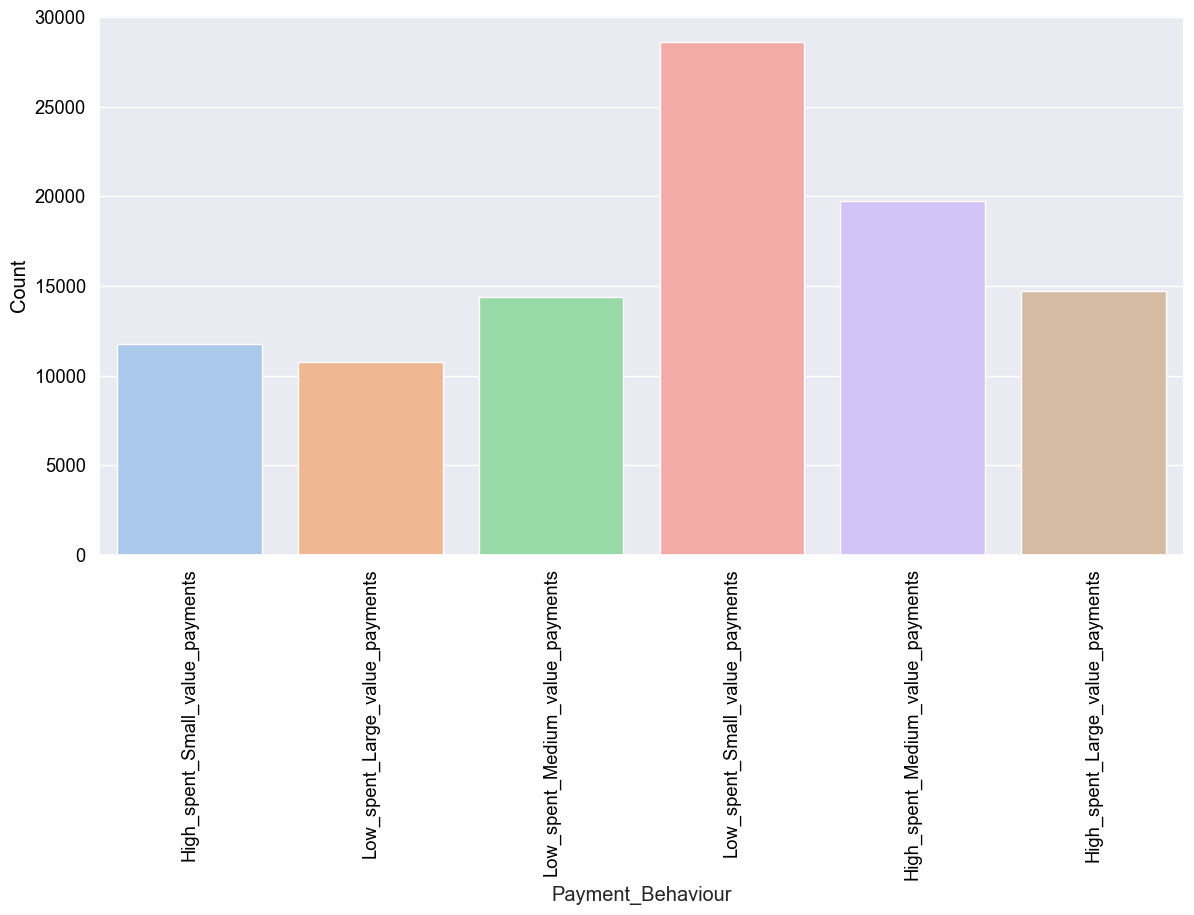

In [71]:
sns.countplot(data['Payment_Behaviour'],palette="pastel");
plt.xticks(rotation=90, color='black');
plt.tick_params(axis='y', colors='black')
plt.ylabel('Count', color="black")
#plt.savefig('countplot2.png', transparent=True)

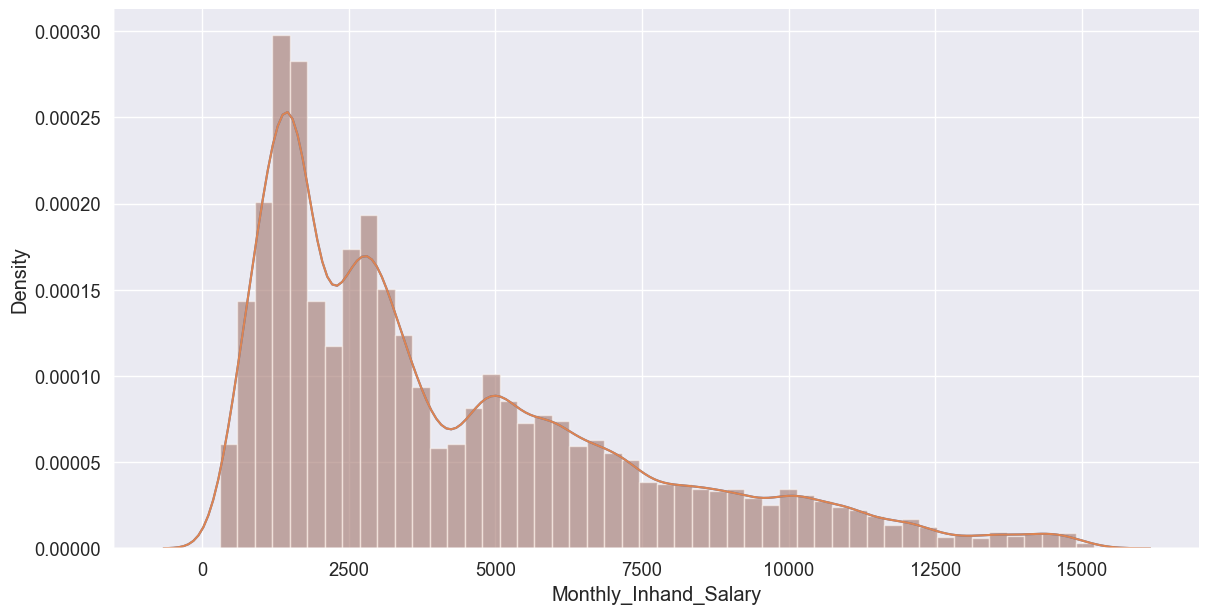

In [72]:
sns.distplot(data['Monthly_Inhand_Salary']);

sns.set_style("ticks", {"xtick.color": "w", "ytick.color": "w", "axes.edgecolor": "w", "axes.labelcolor": "w", "palette": "pastel"})

# Crea el gráfico de distribución de la variable "Monthly_Inhand_Salary"
sns.distplot(data['Monthly_Inhand_Salary'])

# Establece la transparencia de los ejes
plt.gca().spines['top'].set_alpha(0)
plt.gca().spines['right'].set_alpha(0)
plt.gca().spines['bottom'].set_alpha(0.5)
plt.gca().spines['left'].set_alpha(0.5)

# Guarda el gráfico con fondo transparente
#plt.savefig('distplot1.png', transparent=True)

# Restablece el estilo de Seaborn al valor predeterminado
#sns.set_style("whitegrid")

Text(0, 0.5, 'Count')

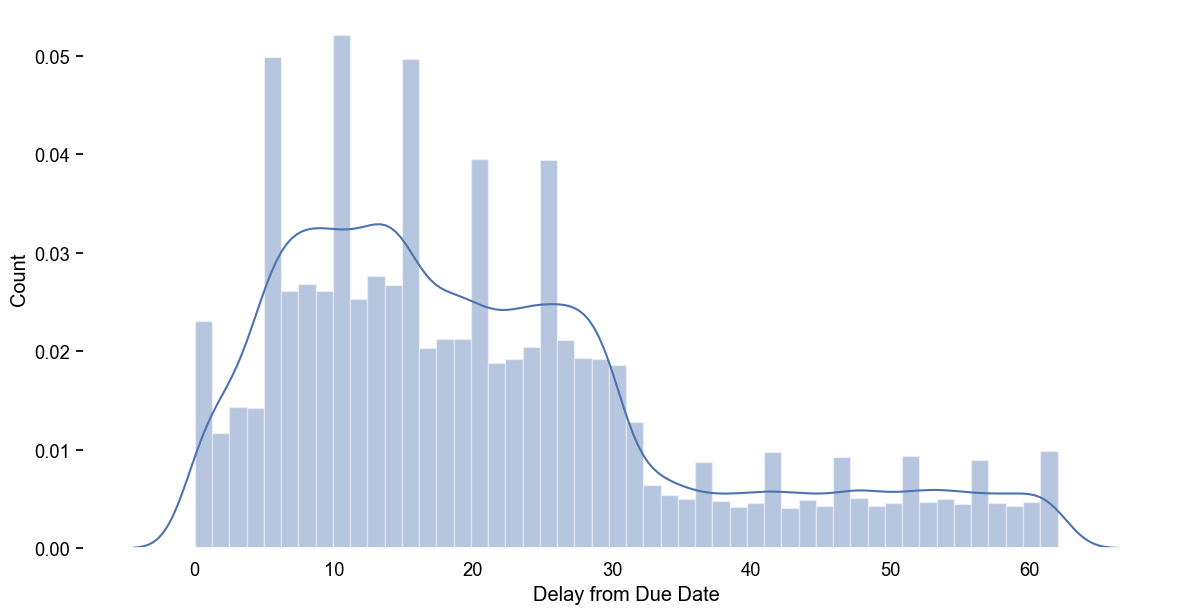

In [73]:
sns.distplot(data['Delay_from_due_date']);
plt.xticks(color='black');
plt.tick_params(axis='y', colors='black')
plt.xlabel('Delay from Due Date', color="black")
plt.ylabel('Count', color="black")
#plt.savefig('delay_from_due_date.png', transparent=True)

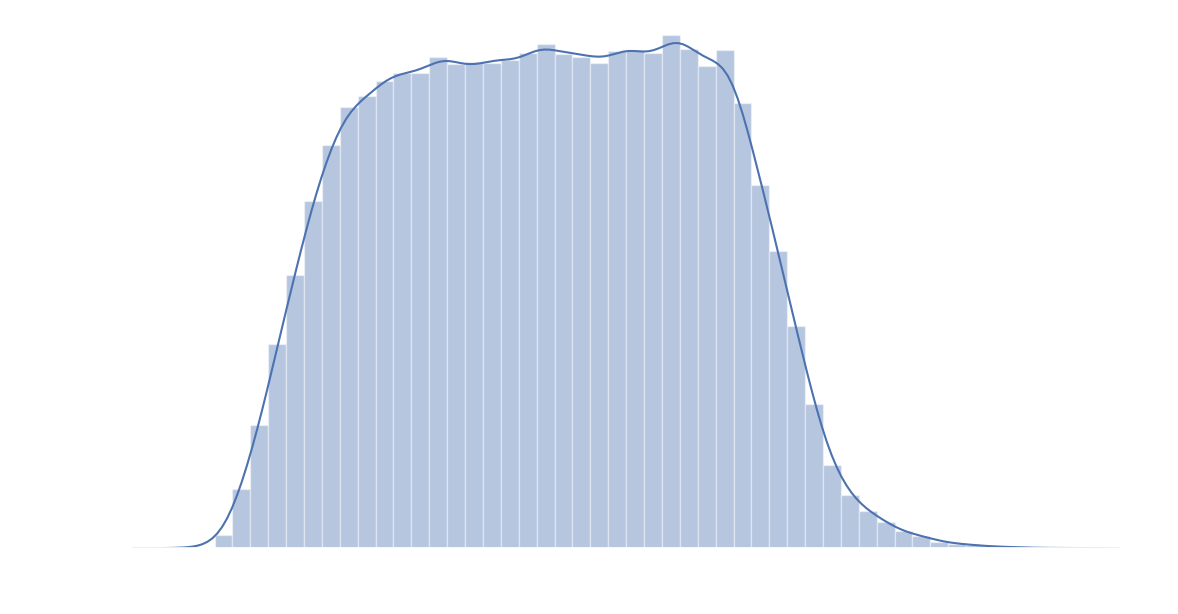

In [74]:
sns.distplot(data['Credit_Utilization_Ratio']);

In [75]:
fig = px.box(data, 
             x="Occupation",  
             color="Credit_Score", 
             title="Credit Scores Based on Occupation", 
             color_discrete_map={'Poor':'red',
                                 'Standard':'yellow',
                                 'Good':'green'})
fig.show()

In [76]:
fig = px.box(data, 
             x="Credit_Score", 
             y="Num_of_Delayed_Payment", 
             color="Credit_Score", 
             title="Credit Scores Based on Number of Delayed Payments",
             color_discrete_map={'Poor':'red',
                                 'Standard':'yellow',
                                 'Good':'green'})
fig.update_traces(quartilemethod="exclusive")
fig.show()

### Feature Enginerring - Preprocessing

In [77]:
data.select_dtypes(include="object")

Name Occupation  \
0      Aaron Maashoh  Scientist   
1      Aaron Maashoh  Scientist   
2      Aaron Maashoh  Scientist   
3      Aaron Maashoh  Scientist   
4      Aaron Maashoh  Scientist   
...              ...        ...   
99995          Nicks   Mechanic   
99996          Nicks   Mechanic   
99997          Nicks   Mechanic   
99998          Nicks   Mechanic   
99999          Nicks   Mechanic   

                                            Type_of_Loan Credit_Mix  \
0      Auto Loan, Credit-Builder Loan, Personal Loan,...       Good   
1      Auto Loan, Credit-Builder Loan, Personal Loan,...       Good   
2      Auto Loan, Credit-Builder Loan, Personal Loan,...       Good   
3      Auto Loan, Credit-Builder Loan, Personal Loan,...       Good   
4      Auto Loan, Credit-Builder Loan, Personal Loan,...       Good   
...                                                  ...        ...   
99995                        Auto Loan, and Student Loan       Good   
99996                        Auto Loan, and Student Loan       Good   
99997                        Auto Loan, and Student Loan       Good   
99998                        Auto Loan, and Student Loan       Good   
99999                        Auto Loan, and Student Loan       Good   

      Payment_of_Min_Amount                 Payment_Behaviour Credit_Score  
0                        No   High_spent_Small_value_payments         Good  
1                        No    Low_spent_Large_value_payments         Good  
2                        No   Low_spent_Medium_value_payments         Good  
3                        No    Low_spent_Small_value_payments         Good  
4                        No  High_spent_Medium_value_payments         Good  
...                     ...                               ...          ...  
99995                    No   High_spent_Large_value_payments         Poor  
99996                    No  High_spent_Medium_value_payments         Poor  
99997                    No   High_spent_Large_value_payments         Poor  
99998                    No    Low_spent_Large_value_payments     Standard  
99999                    No  High_spent_Medium_value_payments         Poor  

[100000 rows x 7 columns]

In [78]:
#Primero, preprocesamos el Target
print(data['Credit_Score'].value_counts())

m = {"Poor": 0,
     "Standard": 1, 
     "Good": 2
     }
data['Credit_Score'] = data['Credit_Score'].map(m)

Standard    53174
Poor        28998
Good        17828
Name: Credit_Score, dtype: int64


In [79]:
#Preprocesamos la col Occupation

data['Occupation'].value_counts()

data = pd.get_dummies(data, columns = ['Occupation'], drop_first=True)

In [80]:
#Arrgelamos la columna Type Of Loan

for i in data['Type_of_Loan'].value_counts().head(9).index[1:] : 
    data[i] = data['Type_of_Loan'].str.contains(i)
    
del data['Type_of_Loan']

In [81]:
#Arrgelamos la columna Credit Mix

data['Credit_Mix'].value_counts()

p = {'Bad': 0,
     'Standard': 1,
     'Good': 2
     }


data['Credit_Mix'] = data['Credit_Mix'].map(p)

In [82]:
#Arrgelamos la columna Payment of Min Amount

data['Payment_of_Min_Amount'].replace("NM", "No", inplace = True)

z = {'No': 0, 
     'Yes': 1
     }

data['Payment_of_Min_Amount'] = data['Payment_of_Min_Amount'].map(z)


In [83]:
#Arrgelamos la columna Payment_Behaviour

data['Payment_Behaviour'].value_counts()

data = pd.get_dummies(data, columns=['Payment_Behaviour'], drop_first=True )

In [84]:
#Data Sampling

X,y = data.drop("Credit_Score", axis = 1), data["Credit_Score"]

In [85]:
#Eliminamos las columnas que a priori no van a servirnos para el modelo

X = X.drop(columns=["ID", "Customer_ID", "Name", "SSN"], axis = 1)

In [86]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 47 columns):
 #   Column                                              Non-Null Count   Dtype  
---  ------                                              --------------   -----  
 0   Month                                               100000 non-null  int64  
 1   Age                                                 100000 non-null  float64
 2   Annual_Income                                       100000 non-null  float64
 3   Monthly_Inhand_Salary                               100000 non-null  float64
 4   Num_Bank_Accounts                                   100000 non-null  float64
 5   Num_Credit_Card                                     100000 non-null  float64
 6   Interest_Rate                                       100000 non-null  float64
 7   Num_of_Loan                                         100000 non-null  float64
 8   Delay_from_due_date                                 100000 non-nu

In [87]:
# Convertimos cada columna uint8 a tipo float

uint8_cols = X.select_dtypes(include=['uint8']).columns.tolist()


for col in uint8_cols:
    X[col] = X[col].astype('float')

In [88]:
# Convertimos cada columna bool a tipo float

bool_cols = X.select_dtypes(include=['bool']).columns.tolist()


for col in bool_cols:
    X[col] = X[col].astype('float')

In [89]:
#Dividimos en train y test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 42)

In [90]:
#Escalamos
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

### MODELO **1**: Logistic Regression "Simple"

In [113]:
lr = LogisticRegression(random_state=55)
lr.fit(X_train_resampled, y_train_resampled)
y_pred = lr.predict(X_test)

In [114]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.68      0.63      0.65      6325
           1       0.59      0.81      0.68      7797
           2       0.83      0.50      0.62      5878

    accuracy                           0.66     20000
   macro avg       0.70      0.64      0.65     20000
weighted avg       0.69      0.66      0.65     20000



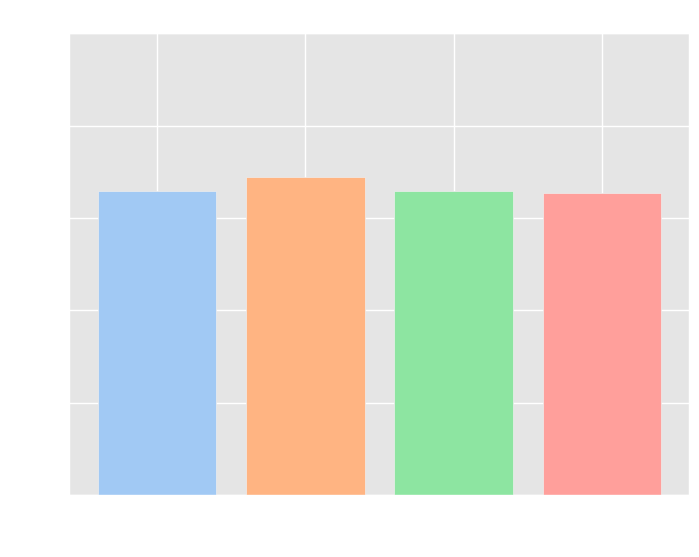

In [136]:
sns.set_palette("pastel")

report = classification_report(y_pred, y_test, output_dict=True)
accuracy = report['accuracy']
precision = report['weighted avg']['precision']
recall = report['weighted avg']['recall']
f1_score = report['weighted avg']['f1-score']

metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
values = [accuracy, precision, recall, f1_score]

colors = sns.color_palette("pastel")

plt.figure(figsize=(8,6), facecolor='none')
plt.bar(metrics, values, color=colors)
plt.title('Model Performance Metrics', color='white')
plt.xlabel('Metrics', color='white')
plt.ylabel('Values', color='white')
plt.ylim([0, 1])
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')
plt.show()


### MODELO **2**: Logistic Regression con Grid Search CV

In [103]:
# Definir los hiperparámetros que se desean evaluar
param_grid = {
    'classifier__penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

# Crear el pipeline que incluye la regresión logística y la búsqueda de hiperparámetros
pipe = Pipeline([('classifier', LogisticRegression(random_state=42))])
grid_search_lr = GridSearchCV(pipe, param_grid=param_grid, cv=5, verbose=0)

# Entrenamos el GridSearch
grid_search_lr.fit(X_train, y_train)

# Imprimir los mejores hiperparámetros y la precisión media en la validación cruzada
print("Mejores hiperparámetros:", grid_search_lr.best_params_)
print("Precisión media en validación cruzada:", grid_search_lr.best_score_)


Mejores hiperparámetros: {'classifier__C': 1, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
Precisión media en validación cruzada: 0.6607000000000001


In [108]:
best_params = {k.replace('classifier__', ''): v for k, v in grid_search_lr.best_params_.items()}
lr2 = LogisticRegression(**best_params)
lr2.fit(X_train, y_train)
y_pred_lr = lr2.predict(X_test)


In [115]:
print(classification_report(y_pred_lr, y_test))

              precision    recall  f1-score   support

           0       0.53      0.68      0.59      4554
           1       0.75      0.68      0.71     11593
           2       0.61      0.56      0.59      3853

    accuracy                           0.66     20000
   macro avg       0.63      0.64      0.63     20000
weighted avg       0.67      0.66      0.66     20000



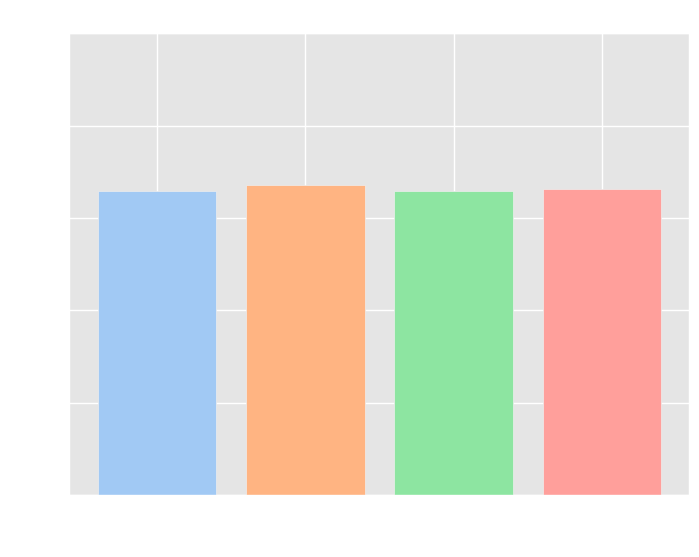

In [137]:
sns.set_palette("pastel")

report = classification_report(y_pred_lr, y_test, output_dict=True)
accuracy = report['accuracy']
precision = report['weighted avg']['precision']
recall = report['weighted avg']['recall']
f1_score = report['weighted avg']['f1-score']

metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
values = [accuracy, precision, recall, f1_score]

colors = sns.color_palette("pastel")

plt.figure(figsize=(8,6), facecolor='none')
plt.bar(metrics, values, color=colors)
plt.title('Model Performance Metrics', color='white')
plt.xlabel('Metrics', color='white')
plt.ylabel('Values', color='white')
plt.ylim([0, 1])
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')
plt.show()

In [ ]:
# Guardamos el modelo

import pickle
with open('modelo_lr.pickle', 'wb') as f:
    pickle.dump(lr2, f)

### MODELO **3**: Combinación 5 modelos de Clasificación

In [139]:
bagging = BaggingClassifier(n_jobs=-1)
extraTrees = ExtraTreesClassifier(max_depth=10, n_jobs=-1)
randomForest = RandomForestClassifier(n_jobs=-1)
histGradientBoosting = HistGradientBoostingClassifier()
XGB = XGBClassifier(n_jobs=-1)

model = StackingClassifier([
    ('bagging', bagging),
    ('extraTress', extraTrees),
    ('randomforest', randomForest),
    ('histGradientBoosting', histGradientBoosting),
    ('XGB', XGB)
], n_jobs=-1)

In [141]:
model.fit(X_train, y_train)

StackingClassifier(estimators=[('bagging', BaggingClassifier(n_jobs=-1)),
                               ('extraTress',
                                ExtraTreesClassifier(max_depth=10, n_jobs=-1)),
                               ('randomforest',
                                RandomForestClassifier(n_jobs=-1)),
                               ('histGradientBoosting',
                                HistGradientBoostingClassifier()),
                               ('XGB',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None...
                                              gpu_id=None, grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_rate=None, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              n_estimators=100, n_jobs=-1,
                                              num_parallel_tree=None,
                                              predictor=None, random_state=None, ...))],
                   n_jobs=-1)

In [142]:
"Train Score: ",model.score(X_train, y_train)

('Train Score: ', 0.9997375)

In [143]:
"Test Score: ",model.score(X_test, y_test)

('Test Score: ', 0.83395)

In [144]:
y_pred_combo = model.predict(X_test)

In [145]:
classification_report(y_pred_combo,y_test)

'              precision    recall  f1-score   support\n\n           0       0.85      0.82      0.83      6055\n           1       0.84      0.85      0.84     10493\n           2       0.80      0.82      0.81      3452\n\n    accuracy                           0.83     20000\n   macro avg       0.83      0.83      0.83     20000\nweighted avg       0.83      0.83      0.83     20000\n'

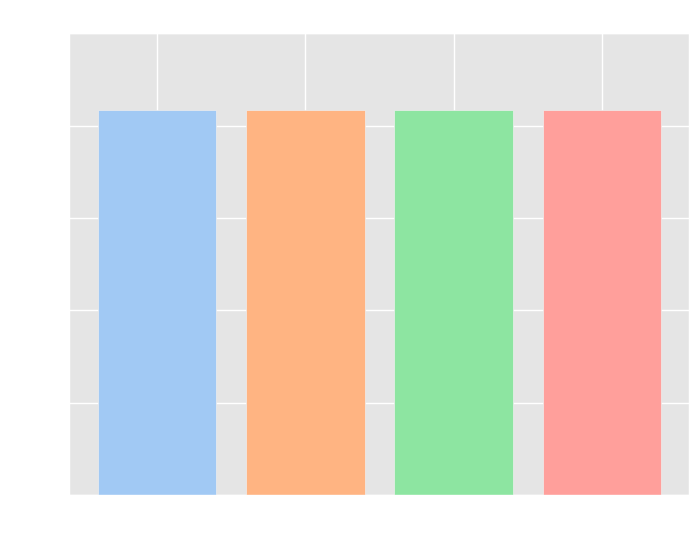

In [146]:
sns.set_palette("pastel")

report = classification_report(y_pred_combo, y_test, output_dict=True)
accuracy = report['accuracy']
precision = report['weighted avg']['precision']
recall = report['weighted avg']['recall']
f1_score = report['weighted avg']['f1-score']

metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
values = [accuracy, precision, recall, f1_score]

colors = sns.color_palette("pastel")

plt.figure(figsize=(8,6), facecolor='none')
plt.bar(metrics, values, color=colors)
plt.title('Model Performance Metrics', color='white')
plt.xlabel('Metrics', color='white')
plt.ylabel('Values', color='white')
plt.ylim([0, 1])
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')
plt.show()

In [99]:
#Guardamos el modelo

import pickle
with open('modelo_xgb.pickle', 'wb') as f:
    pickle.dump(model, f)

### MODELO **4**: XGB con GridSearch

In [118]:
#MODELO
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

model_xgb = xgb.XGBClassifier()

parameters = {
    'learning_rate': [0.1, 0.01, 1],
    'max_depth': [3, 5, 4],
    'n_estimators': [200, 500]
}


grid_search_xgb = GridSearchCV(model_xgb, param_grid=parameters, cv=3)
grid_search_xgb.fit(X_train, y_train)

print("Mejores parámetros:", grid_search_xgb.best_params_)
print("Mejor puntuación:", grid_search_xgb.best_score_)
 

Mejores parámetros: {'learning_rate': 1, 'max_depth': 5, 'n_estimators': 500}
Mejor puntuación: 0.7953374814983117


In [119]:
model_xgb = xgb.XGBClassifier(**grid_search_xgb.best_params_)
model_xgb.fit(X_train, y_train)
y_pred_xgb = model_xgb.predict(y_test)

In [122]:
classification_report(y_pred_xgb,y_test)

'              precision    recall  f1-score   support\n\n           0       0.00      0.00      0.00         0\n           1       1.00      0.53      0.69     20000\n           2       0.00      0.00      0.00         0\n\n    accuracy                           0.53     20000\n   macro avg       0.33      0.18      0.23     20000\nweighted avg       1.00      0.53      0.69     20000\n'

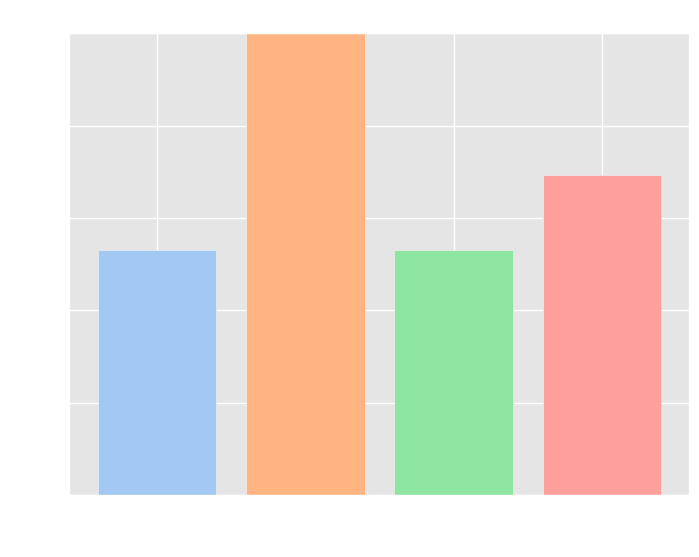

In [147]:
sns.set_palette("pastel")

report = classification_report(y_pred_xgb, y_test, output_dict=True)
accuracy = report['accuracy']
precision = report['weighted avg']['precision']
recall = report['weighted avg']['recall']
f1_score = report['weighted avg']['f1-score']

metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
values = [accuracy, precision, recall, f1_score]

colors = sns.color_palette("pastel")

plt.figure(figsize=(8,6), facecolor='none')
plt.bar(metrics, values, color=colors)
plt.title('Model Performance Metrics', color='white')
plt.xlabel('Metrics', color='white')
plt.ylabel('Values', color='white')
plt.ylim([0, 1])
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')
plt.show()

In [121]:
import pickle
with open('modelo_xgb2.pickle', 'wb') as f:
    pickle.dump(model_xgb, f)